In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from ProcessDataFunctions import datTXT_to_DF
from ProcessDataFunctions import datROOT_to_DF
from ProcessDataFunctions import apply_pedestal_corrections
import uproot as ur
import matplotlib.colors as mcolors
import numpy as np
from scipy.optimize import curve_fit

In [29]:
#data_df = pd.read_pickle("1-63-60-beam_DF.pkl")
data_df = datTXT_to_DF("/Users/seanbp/Documents/Data/GenII_Prototype_Data/JLab/Beam/63-60/Run1_list.txt")
ped_df = pd.read_pickle("Ped_63_60.pkl")
data_df = apply_pedestal_corrections(data_df, ped_df)
mip_df = pd.read_pickle("MIP_DF.pkl")

In [30]:
print(data_df)

          CAEN  CAEN_ch  channel      LG      HG  HG_ped_corr  LG_ped_corr
0            1        0       64   115.0   122.0     0.000000     0.000000
1            1        1       65   121.0   222.0     0.000000     0.000000
2            1        2       66   105.0   176.0     0.000000     0.000000
3            1        3       67   115.0   232.0     0.000000     0.000000
4            1        4       68   130.0   239.0     0.000000     0.000000
...        ...      ...      ...     ...     ...          ...          ...
37916923     0       59       59   187.0  1223.0  1036.084838    76.211807
37916924     0       60       60   231.0  1347.0  1169.930019   122.186429
37916925     0       61       61   441.0  4841.0  4668.168156   333.663904
37916926     0       62       62  1300.0  8002.0  7805.847584  1190.811970
37916927     0       63       63    95.0   129.0     0.000000     0.000000

[37916928 rows x 7 columns]


In [33]:
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

def linear(x, m, b):
    return m * x + b

def plot_gain_ratios(df, caen_unit):
    configure_plotting()
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    num_rows, num_cols = 8, 8
    num_channels = 64

    for i in range(num_channels):
        ax = axes[i // num_cols][i % num_cols]
        channel_id = caen_unit * 64 + i

        mip = float(mip_df.loc[mip_df["channel"] == channel_id, "MIPs"].iloc[0])
        
        ax.axhline(y=mip, color='red', linestyle='--', lw=1)
        ax.axhline(y=mip/2, color='blue', linestyle='--', lw=1)

        # Mask data for this channel
        data = df[df["channel"] == channel_id]

        lg = data["LG_ped_corr"].values
        hg = data["HG_ped_corr"].values

        # 2D histogram
        h = ax.hist2d(
            lg, hg,
            bins=50,
            range=[(0.1, 800), (0.1, 7500)],
            cmap='viridis',
            norm=mcolors.LogNorm()
        )

        # Fit linear function
        try:
            popt, pcov = curve_fit(linear, lg[(lg>0) & (hg>mip/2) & (hg < 7500)], hg[(lg>0) & (hg>mip/2)& (hg < 7500)], p0=[12, 0])
            m_fit, b_fit = popt
            perr = np.sqrt(np.diag(pcov))  # Standard errors on the parameters
            m_err, b_err = perr
            GainRatios.append(m_fit)
            GainRatiosErr.append(m_err)
            # Plot fitted line
            x_fit = np.linspace(0, 800, 100)
            y_fit = linear(x_fit, *popt)
            ax.plot(x_fit, y_fit, color='red', lw=1, label=f"Slope = {round(m_fit, 2)}")
            ax.legend(fontsize=6)
        except Exception:
            GainRatios.append(np.nan)
            GainRatiosErr.append(np.nan)
            ax.set_title("Fit failed", fontsize=6)

        # Axis labels
        if i % num_cols == 0:
            ax.set_ylabel("HG")
        else:
            ax.set_yticks([])
        if i >= num_channels - num_cols:
            ax.set_xlabel("LG")
        else:
            ax.set_xticks([])

        ax.set_xlim(0, 800)
        ax.set_ylim(0, 8000)

    fig.suptitle(f"CAEN {caen_unit} Gain Ratios (HG vs LG)", fontsize=16)
  
    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()


def plot_combined_gain(df):
    configure_plotting()

    #hg = df["HG_ped_corr"].values
    #lg = df["LG_ped_corr"].values

    # Filter non-zero entries
    mask = (hg > 0) & (lg > 0)
    hg = hg[mask]
    lg = lg[mask]

    # Plot
    fig, ax = plt.subplots(figsize=(15, 15))
    h = ax.hist2d(
        lg, hg,
        bins=100,
        range=[(0.1, 800), (0.1, 7500)],
        cmap="viridis",
        norm=mcolors.LogNorm()
    )

    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label("Counts")

    # Fit
    try:
        popt, _ = curve_fit(linear, lg[(lg>0) & (hg>0) & (hg < 7500)], hg[(lg>0) & (hg>0)& (hg < 7500)], p0=[12, 0])
        m_fit, b_fit = popt

        # Plot fit
        x_fit = np.linspace(0, 800, 200)
        y_fit = linear(x_fit, *popt)
        ax.plot(x_fit, y_fit, color="red", label=f"Slope = {round(m_fit, 2)}")
        ax.legend()
    except Exception as e:
        print(f"Fit failed: {e}")

    ax.set_xlabel("LG")
    ax.set_ylabel("HG")
    ax.set_title("Combined HG vs LG")

    fig.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


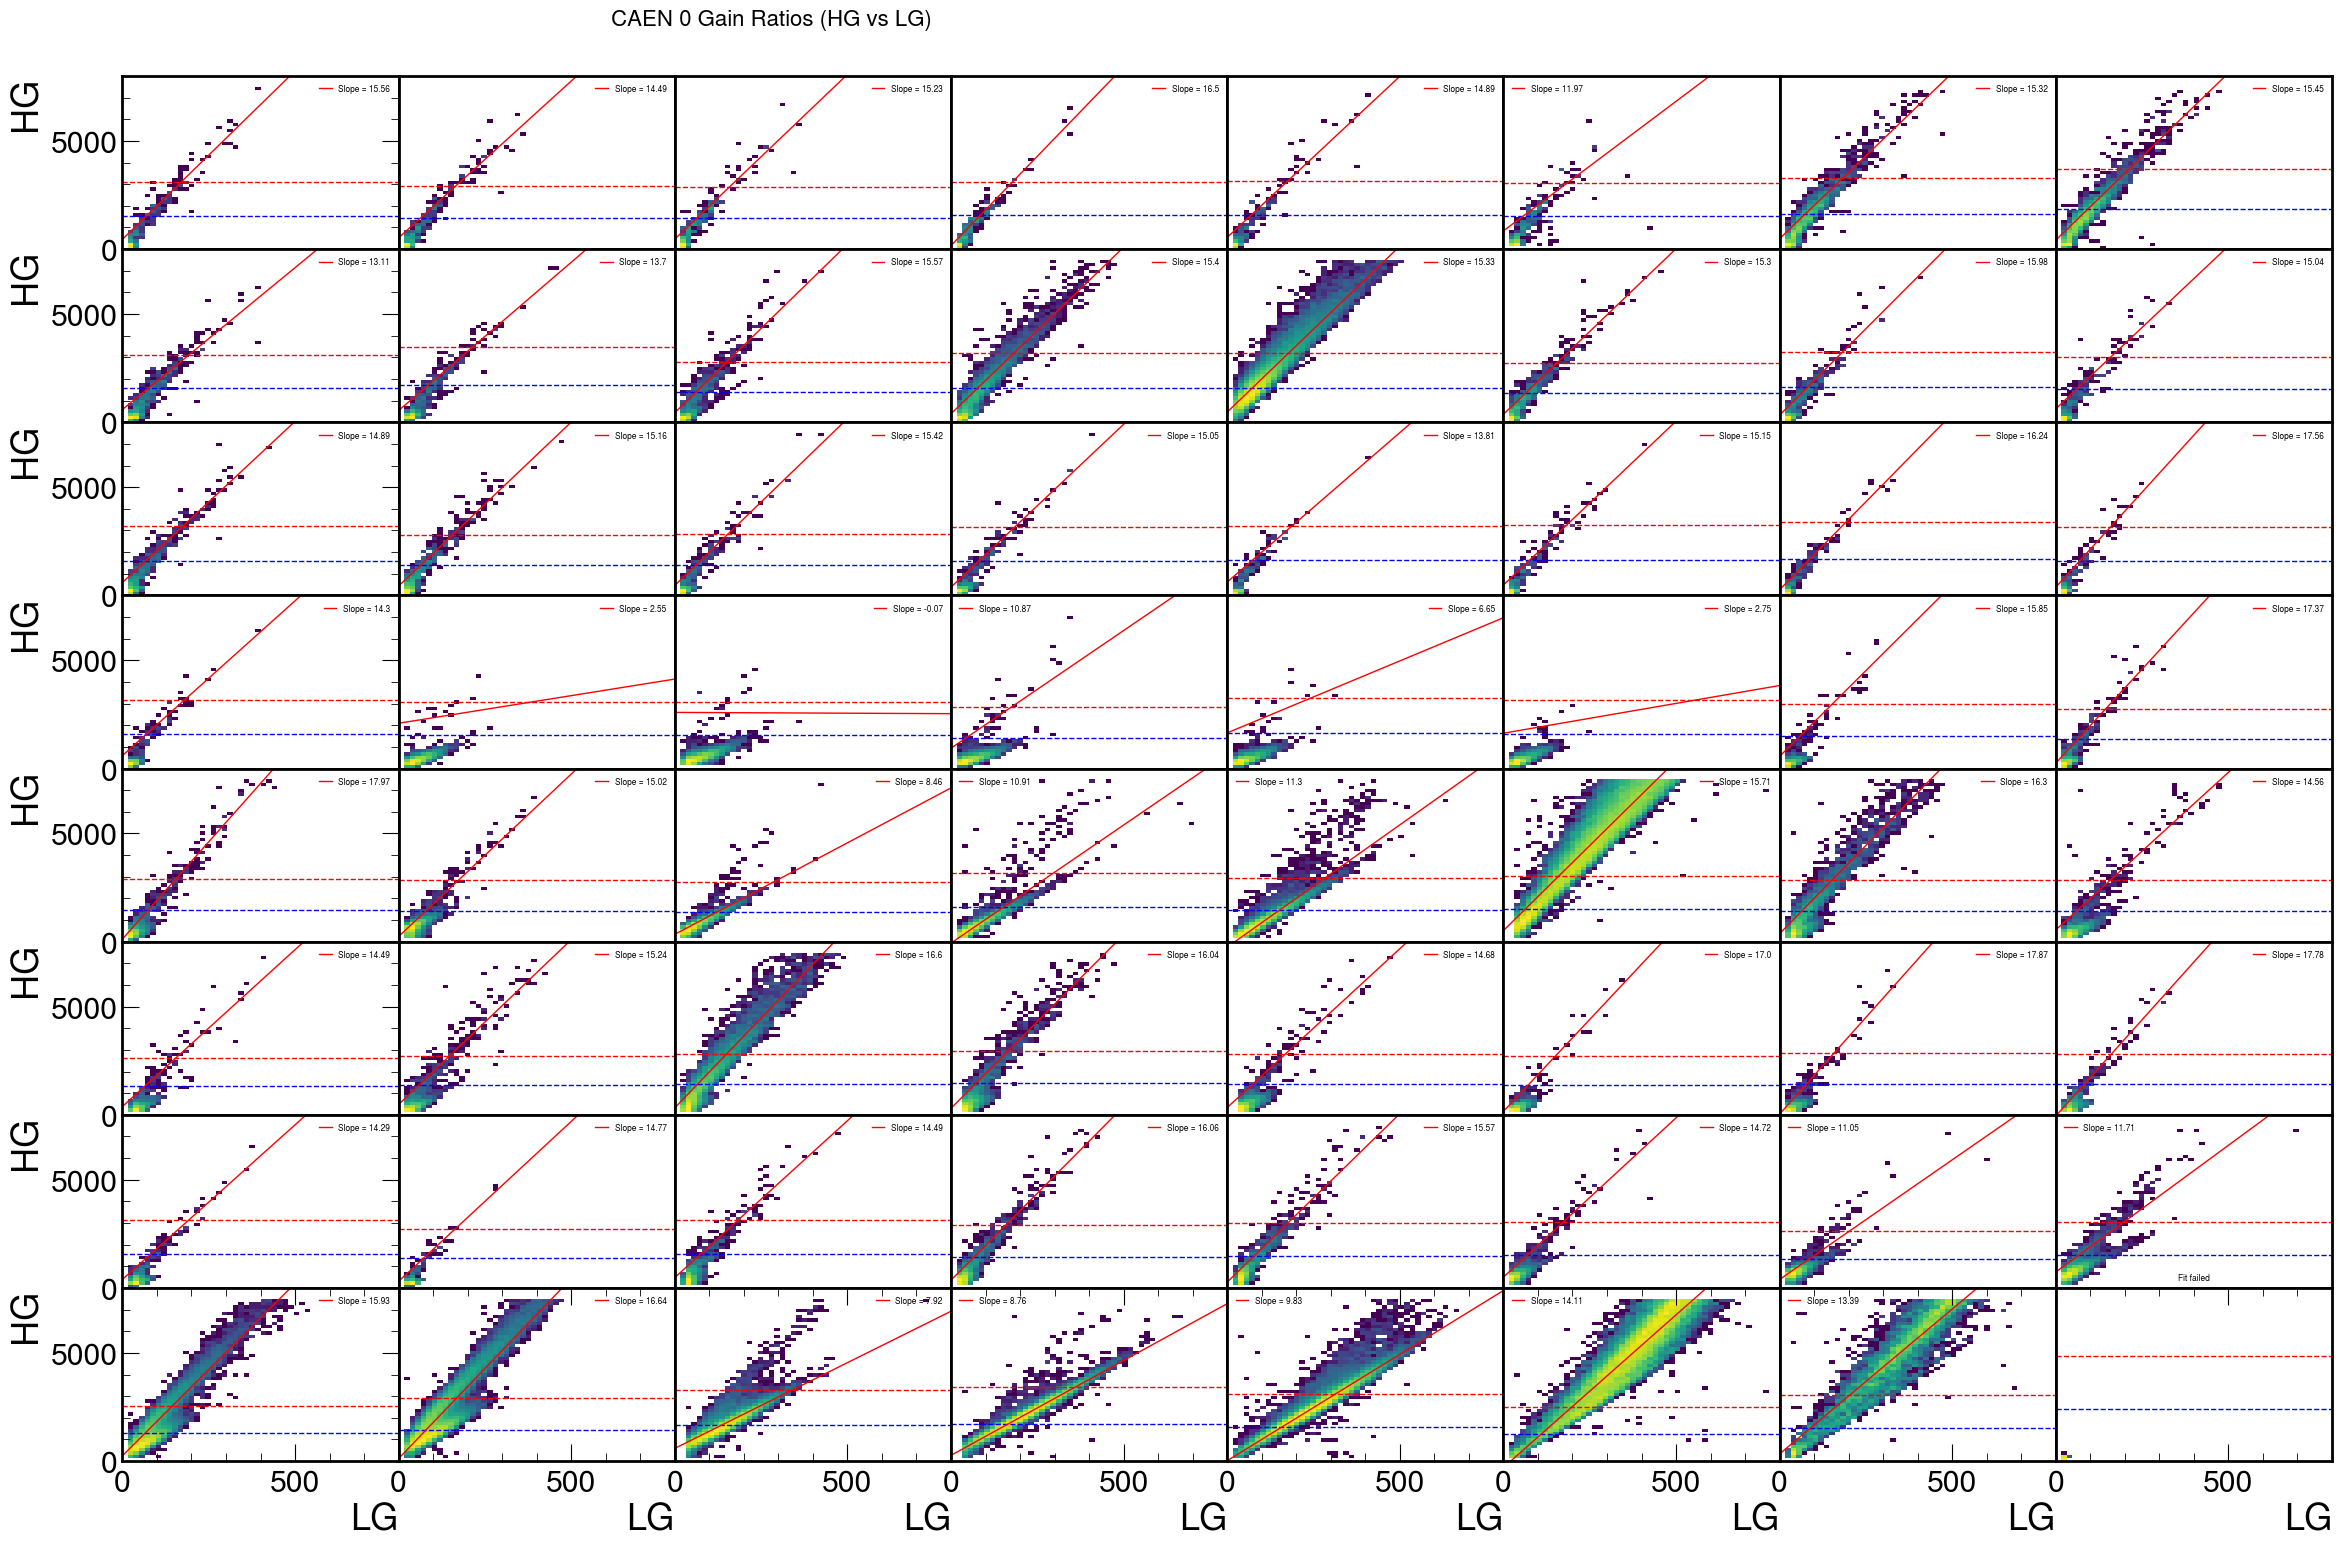

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2473/3401746735.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, lg[(lg>0) & (hg>mip/2) & (hg < 7500)], hg[(lg>0) & (hg>mip/2)& (hg < 7500)], p0=[12, 0])


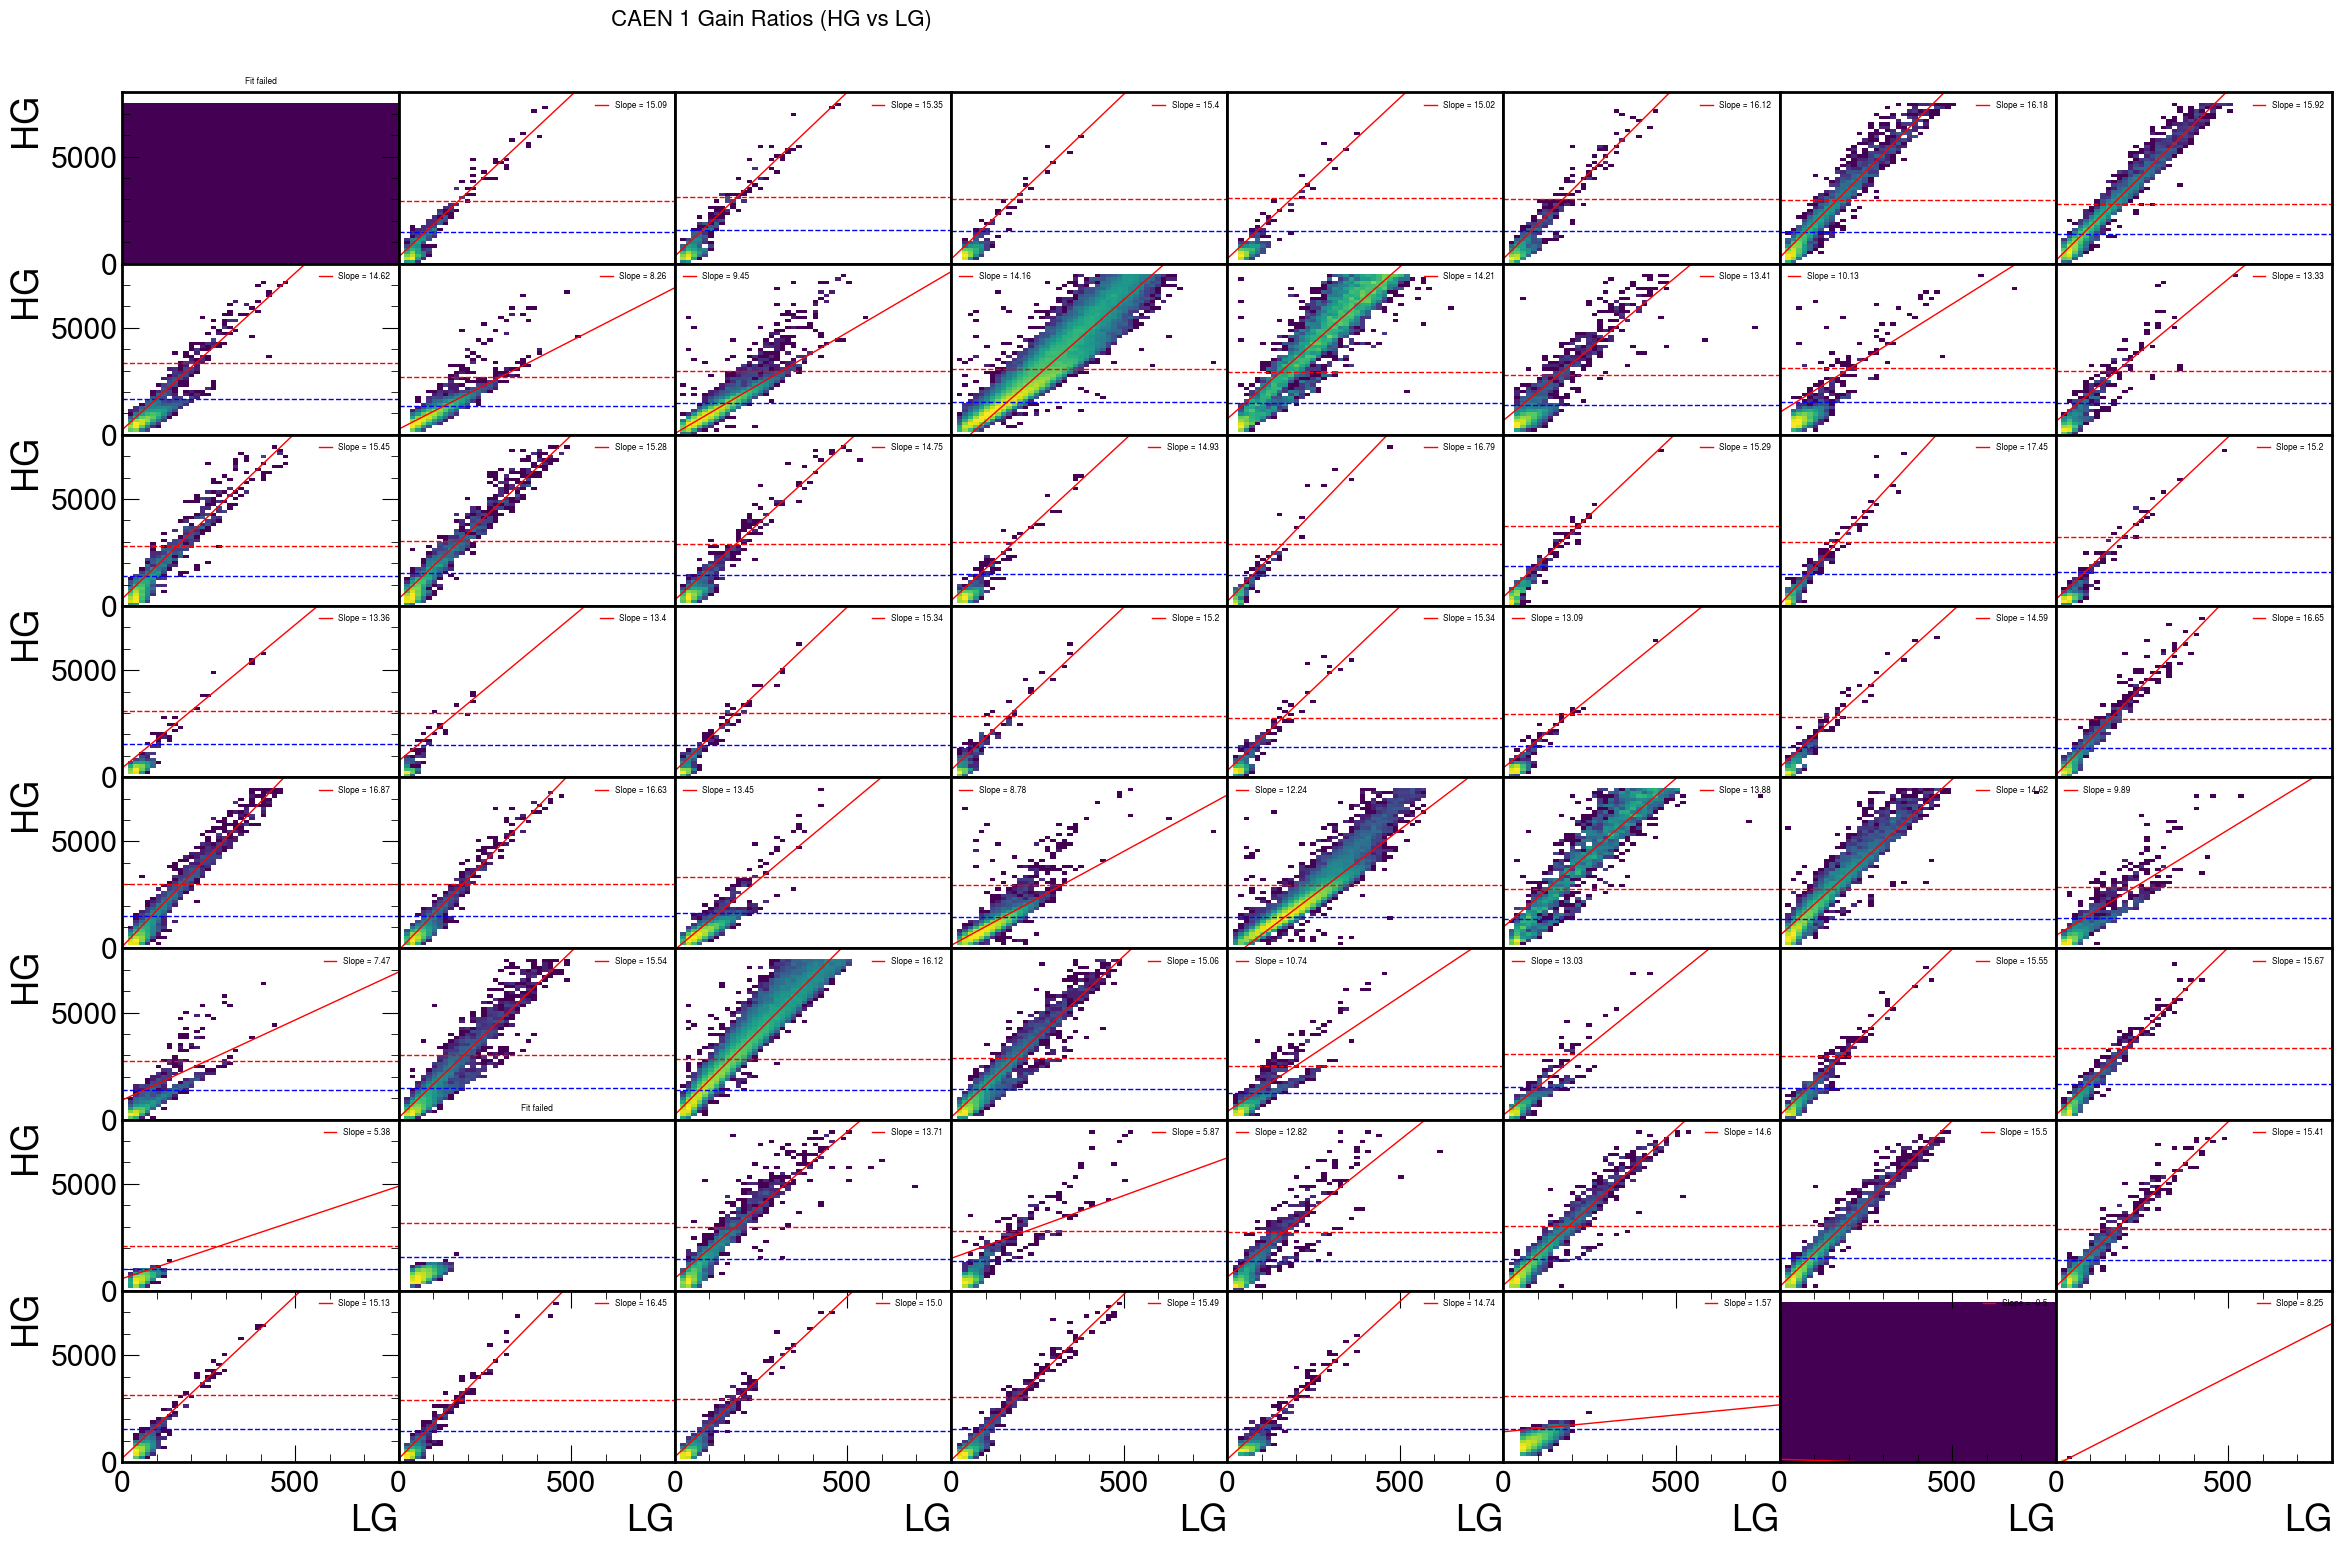

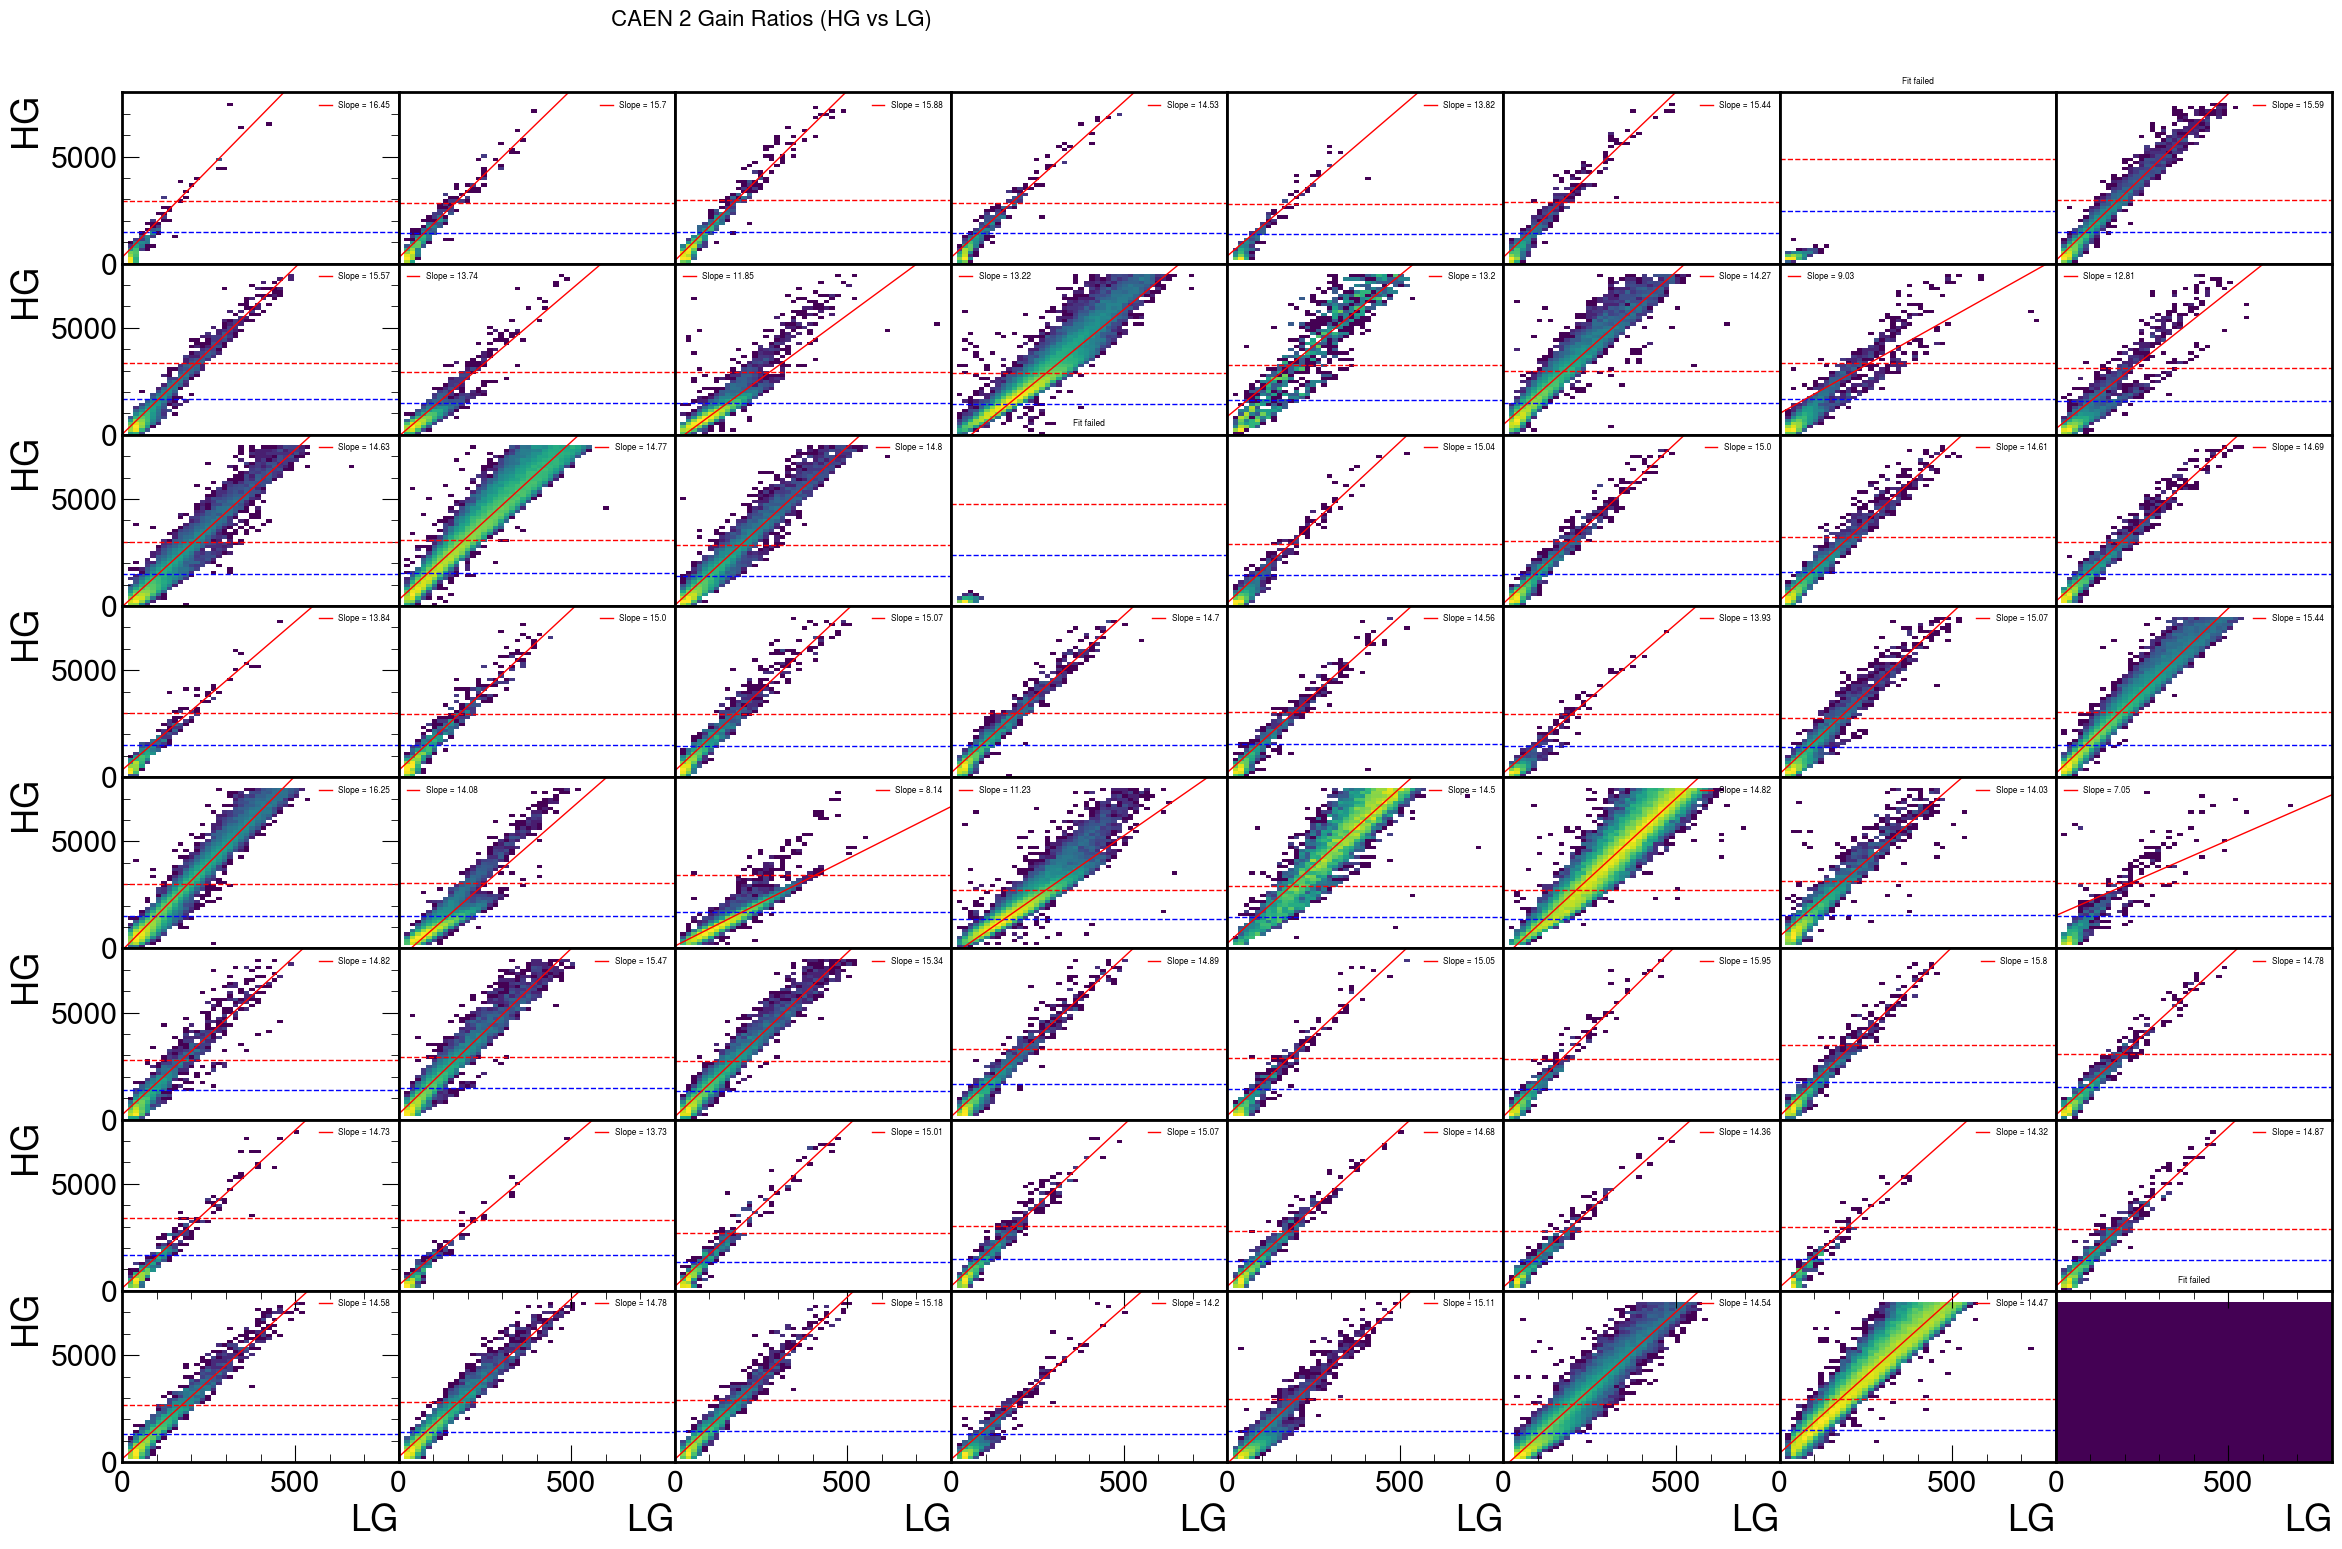

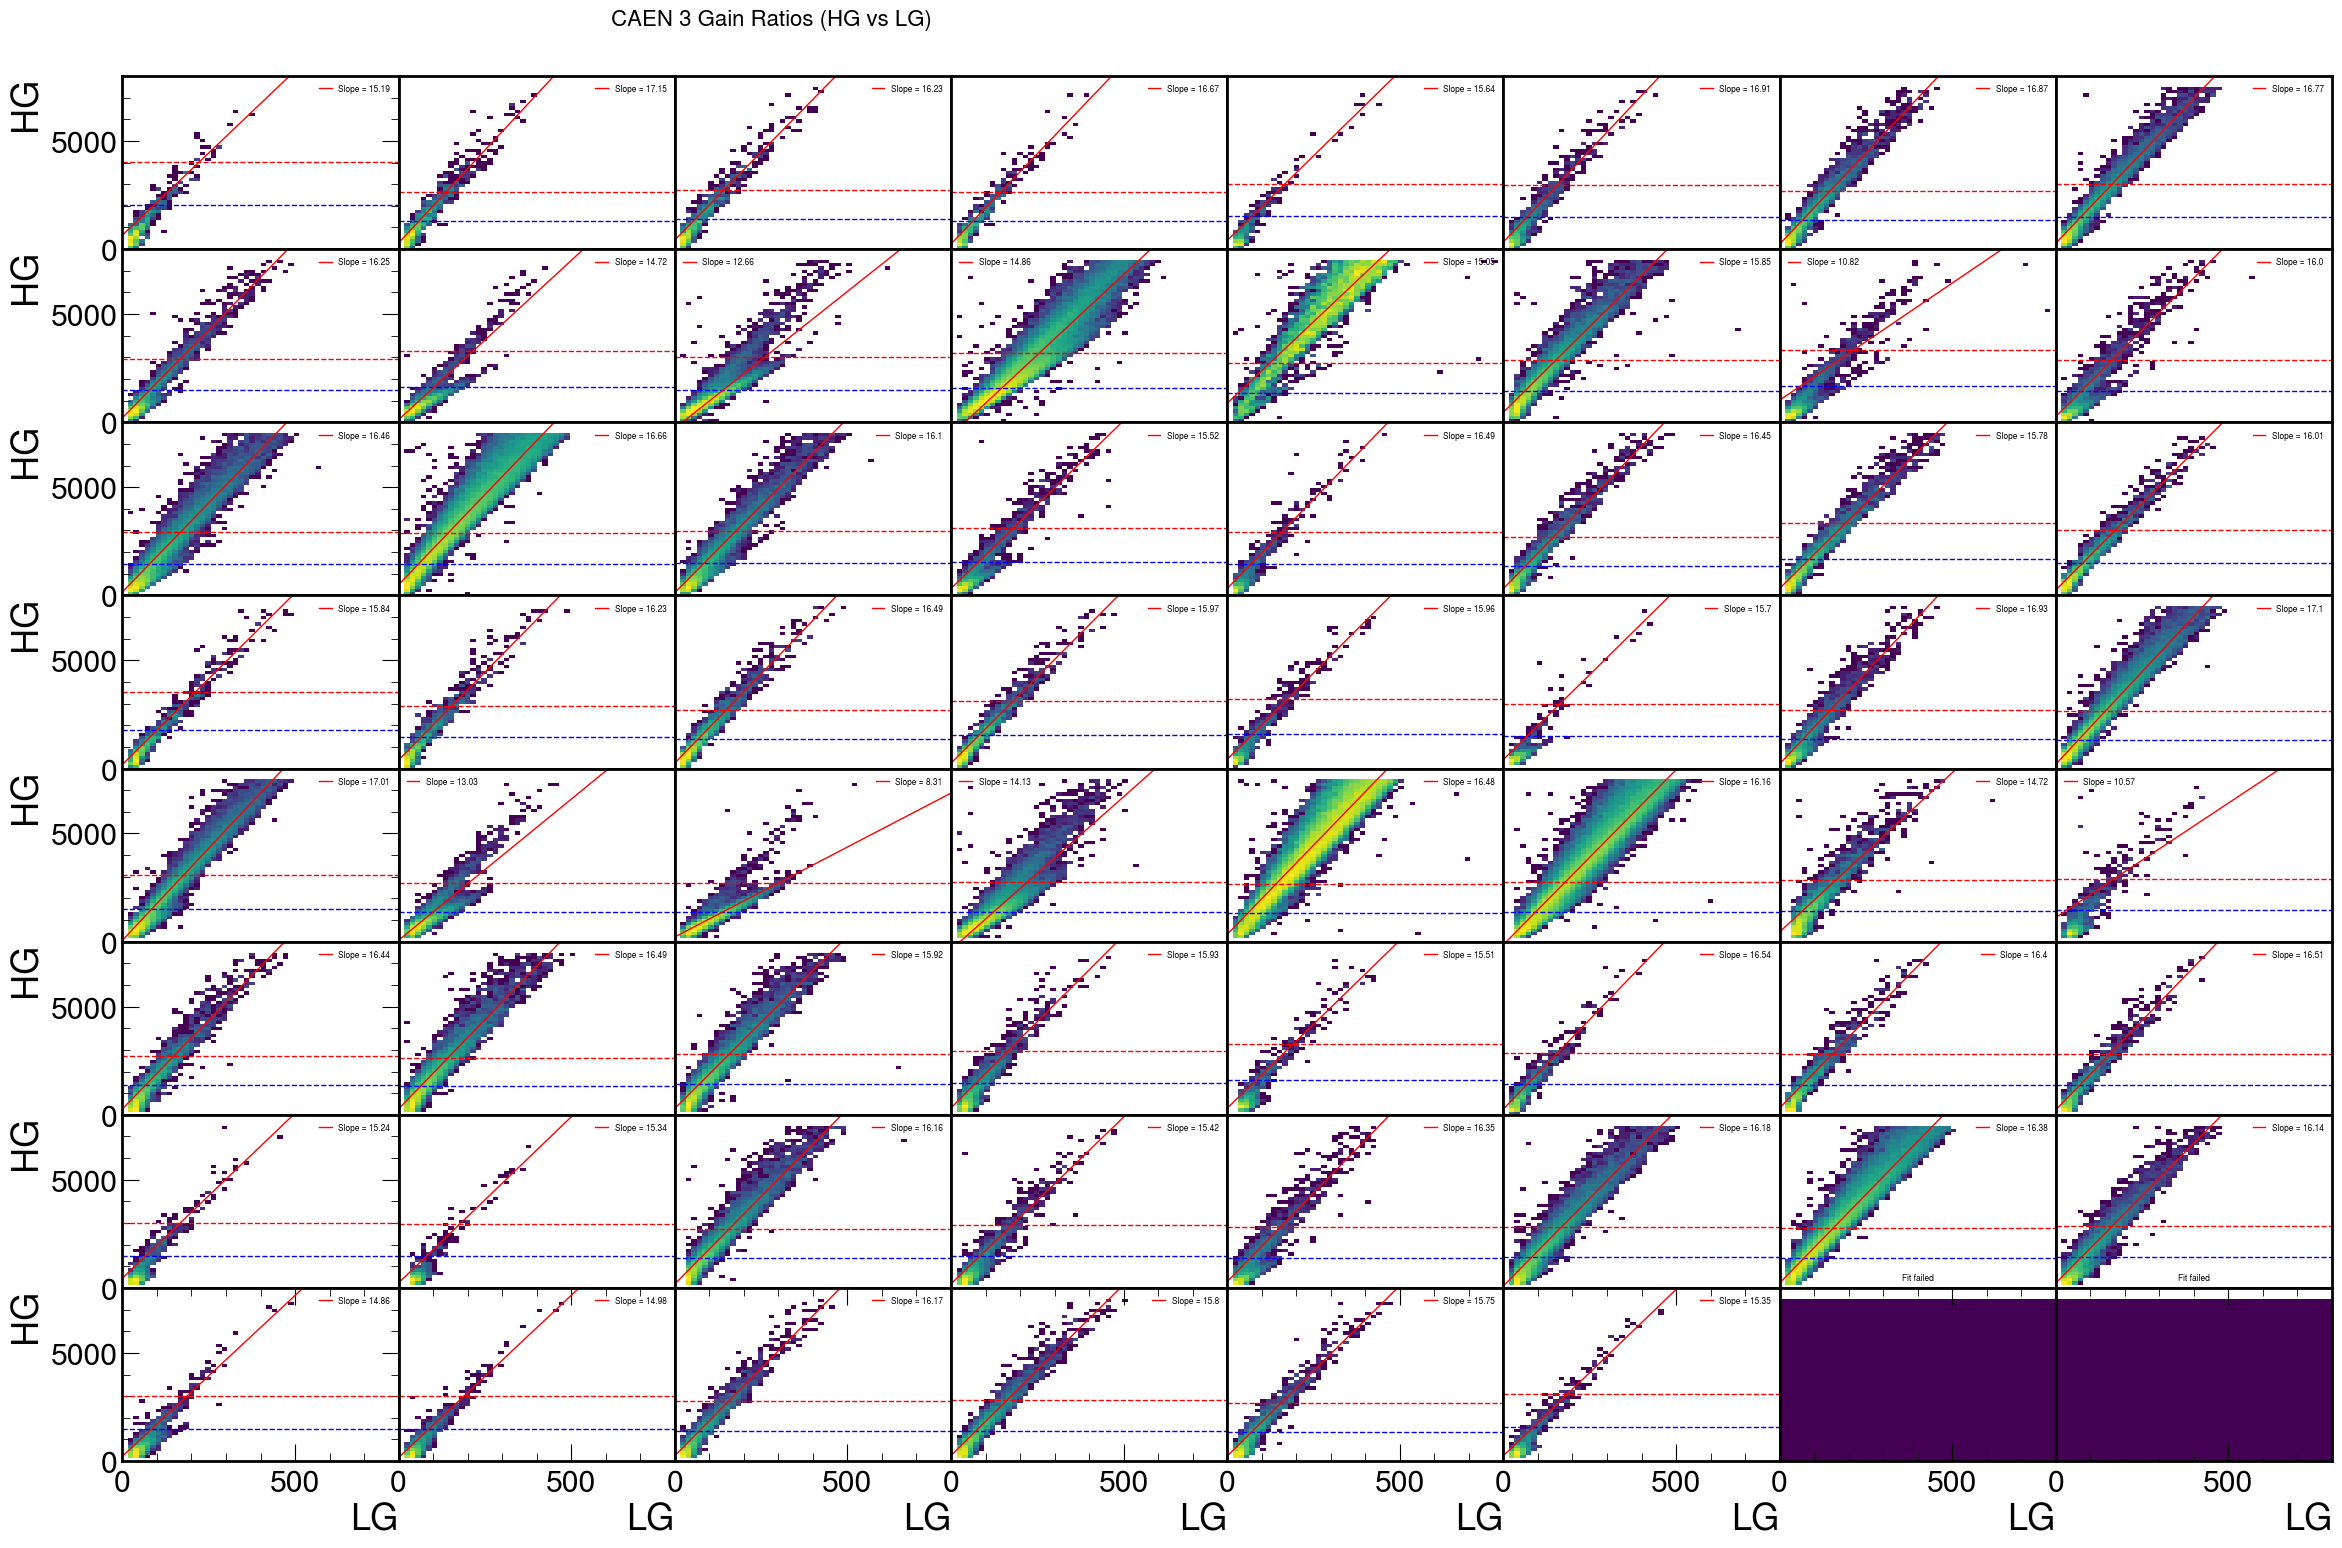

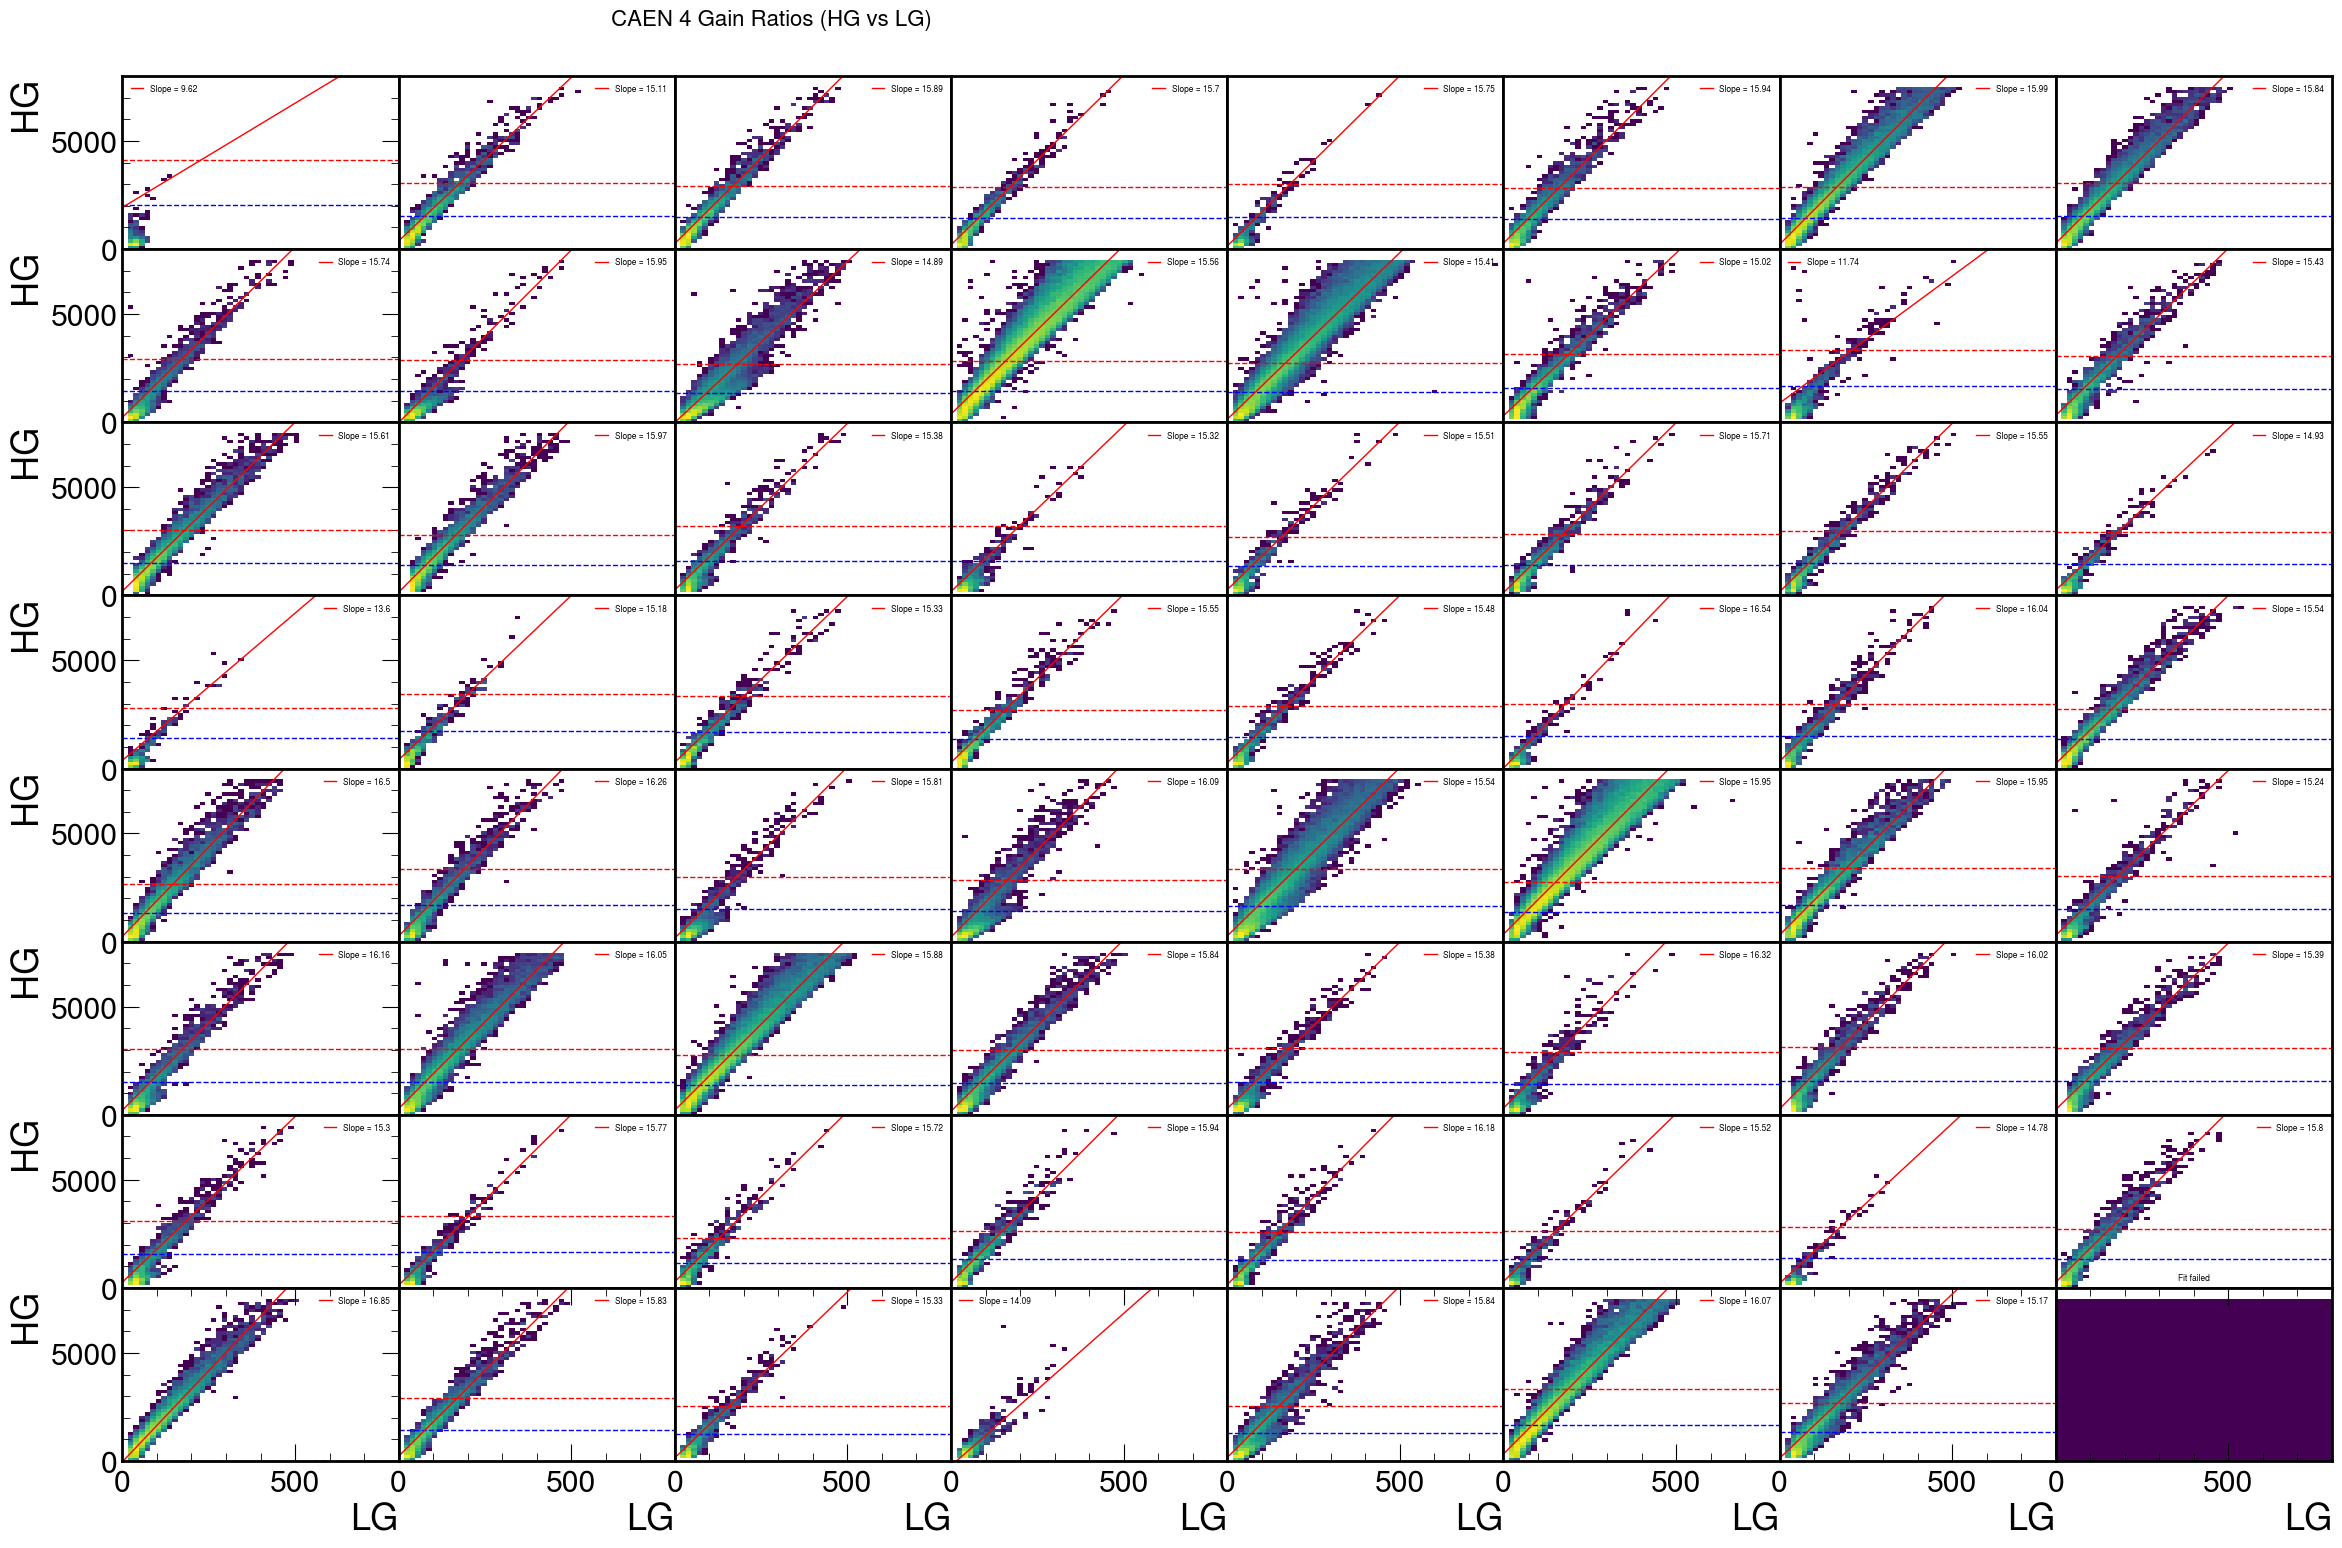

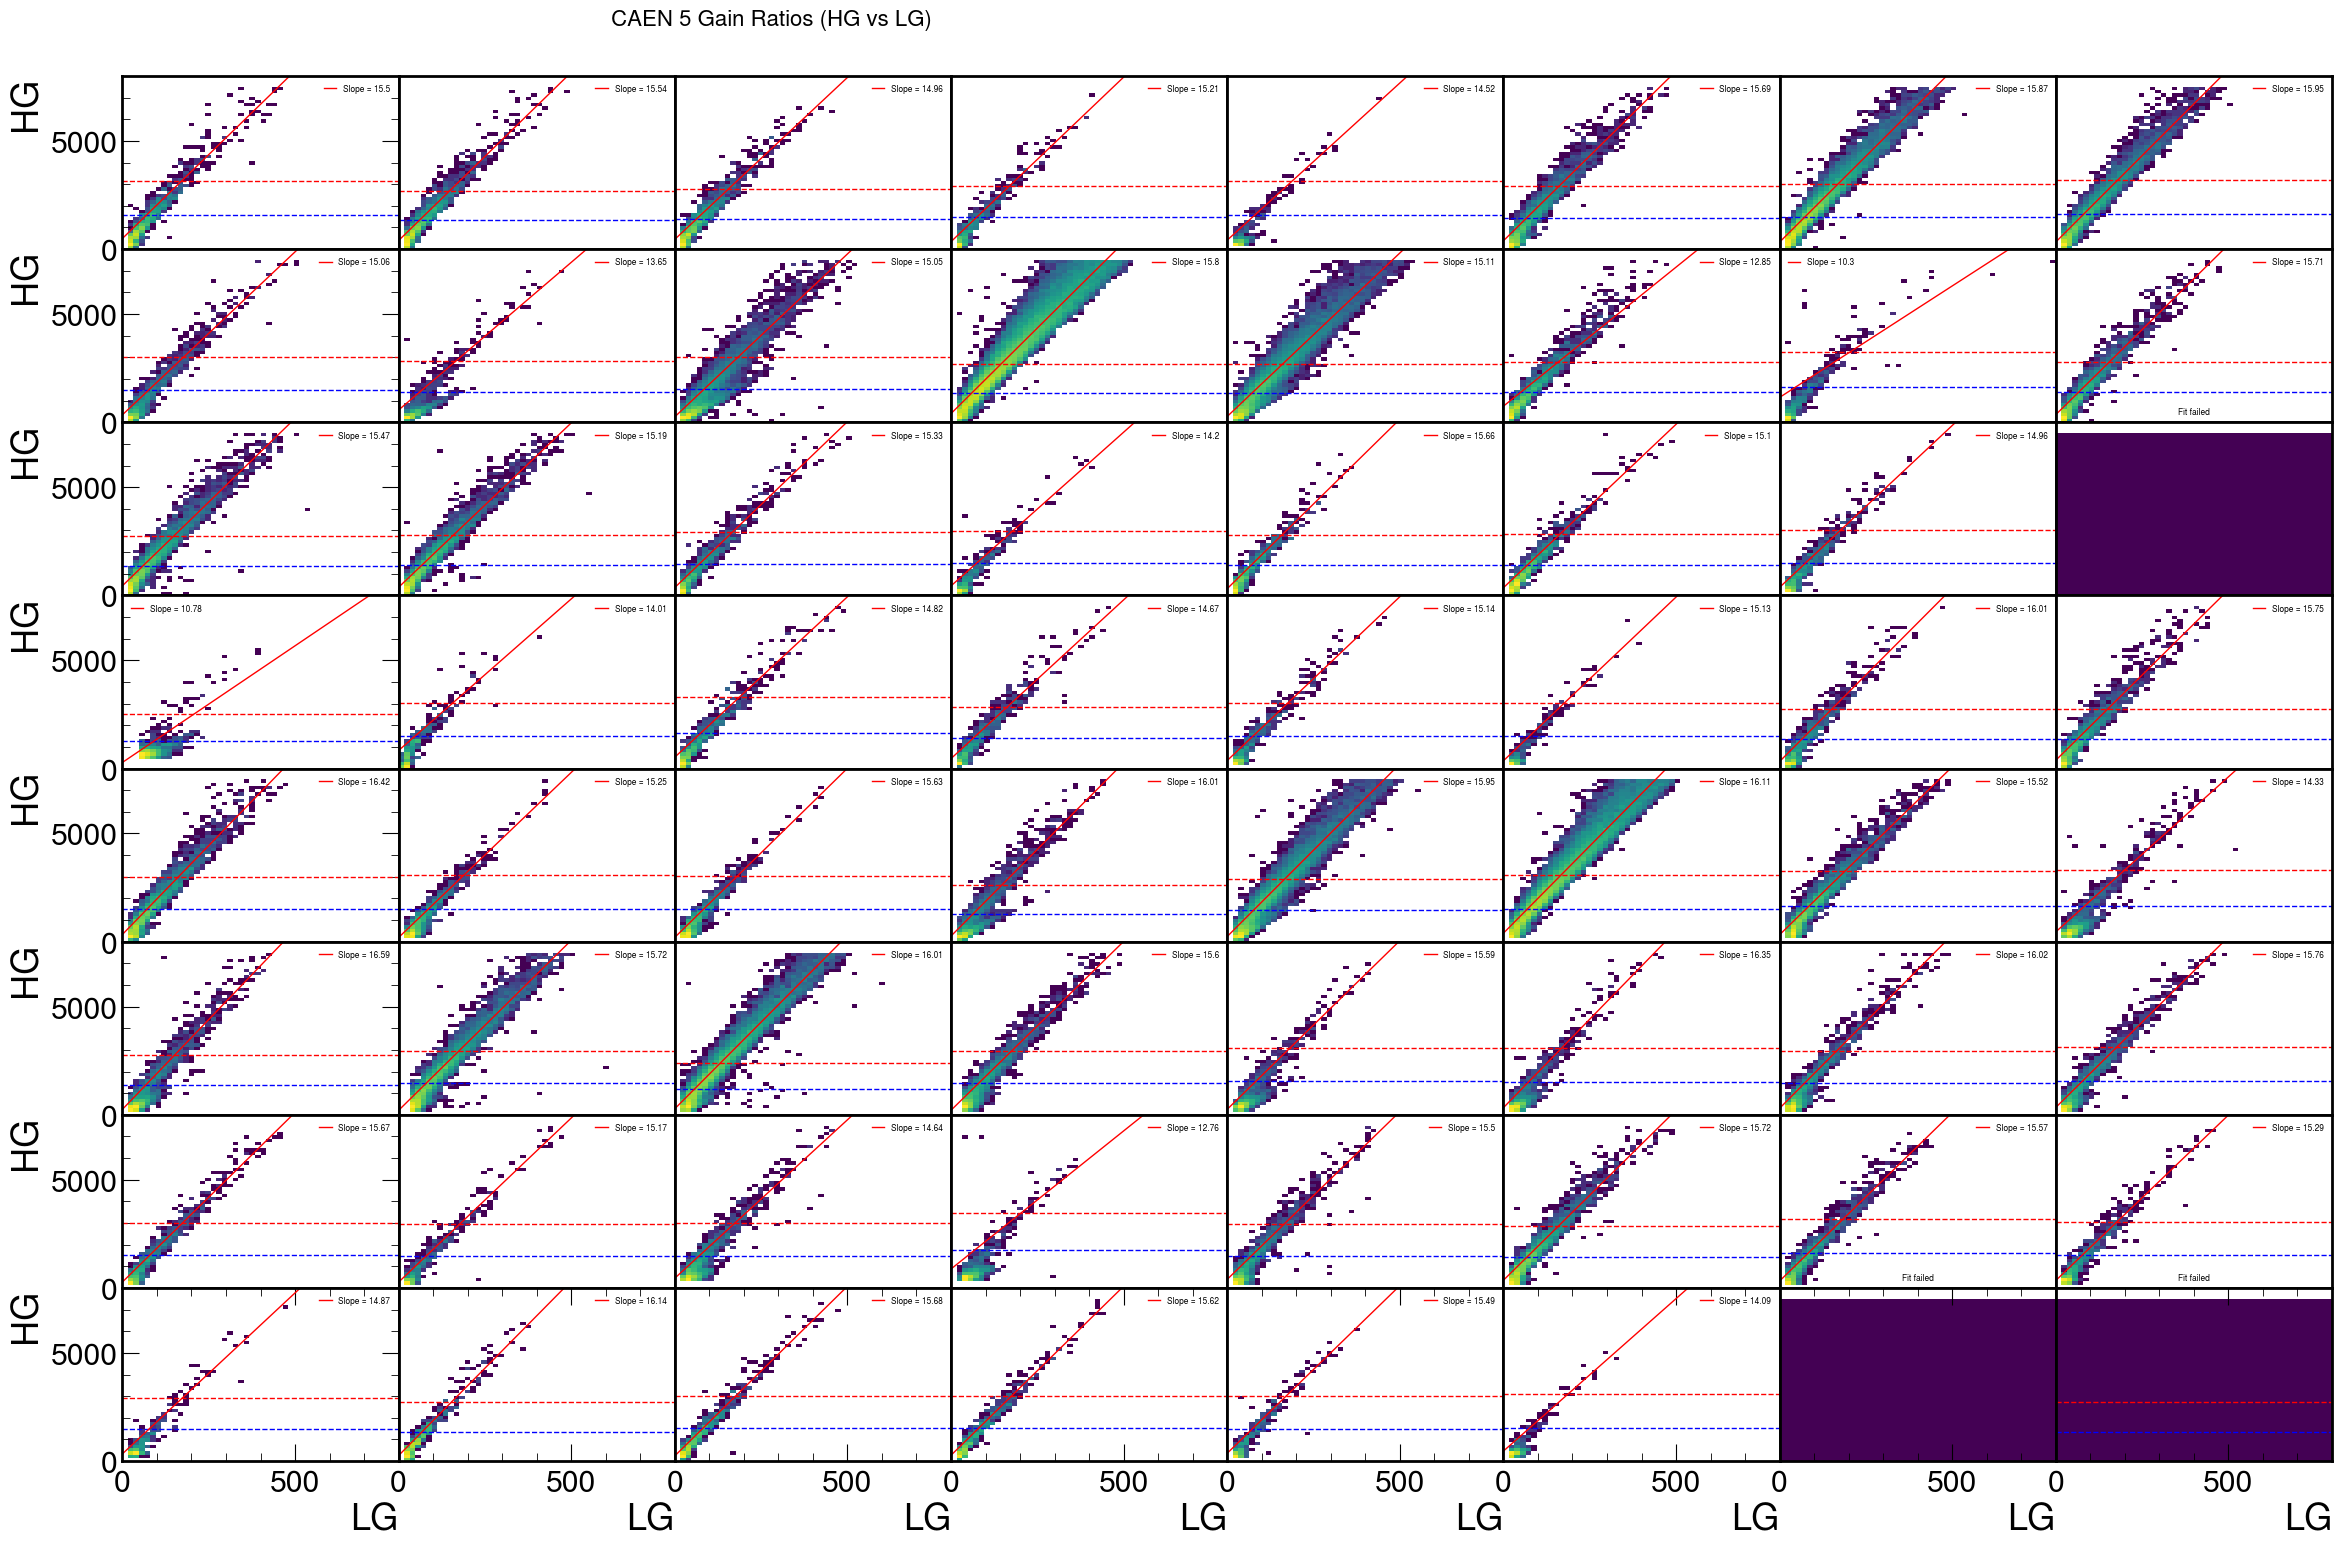

In [34]:
GainRatios = []
GainRatiosErr = []
configure_plotting()
for i in range(6):
    plot_gain_ratios(data_df, caen_unit=i)

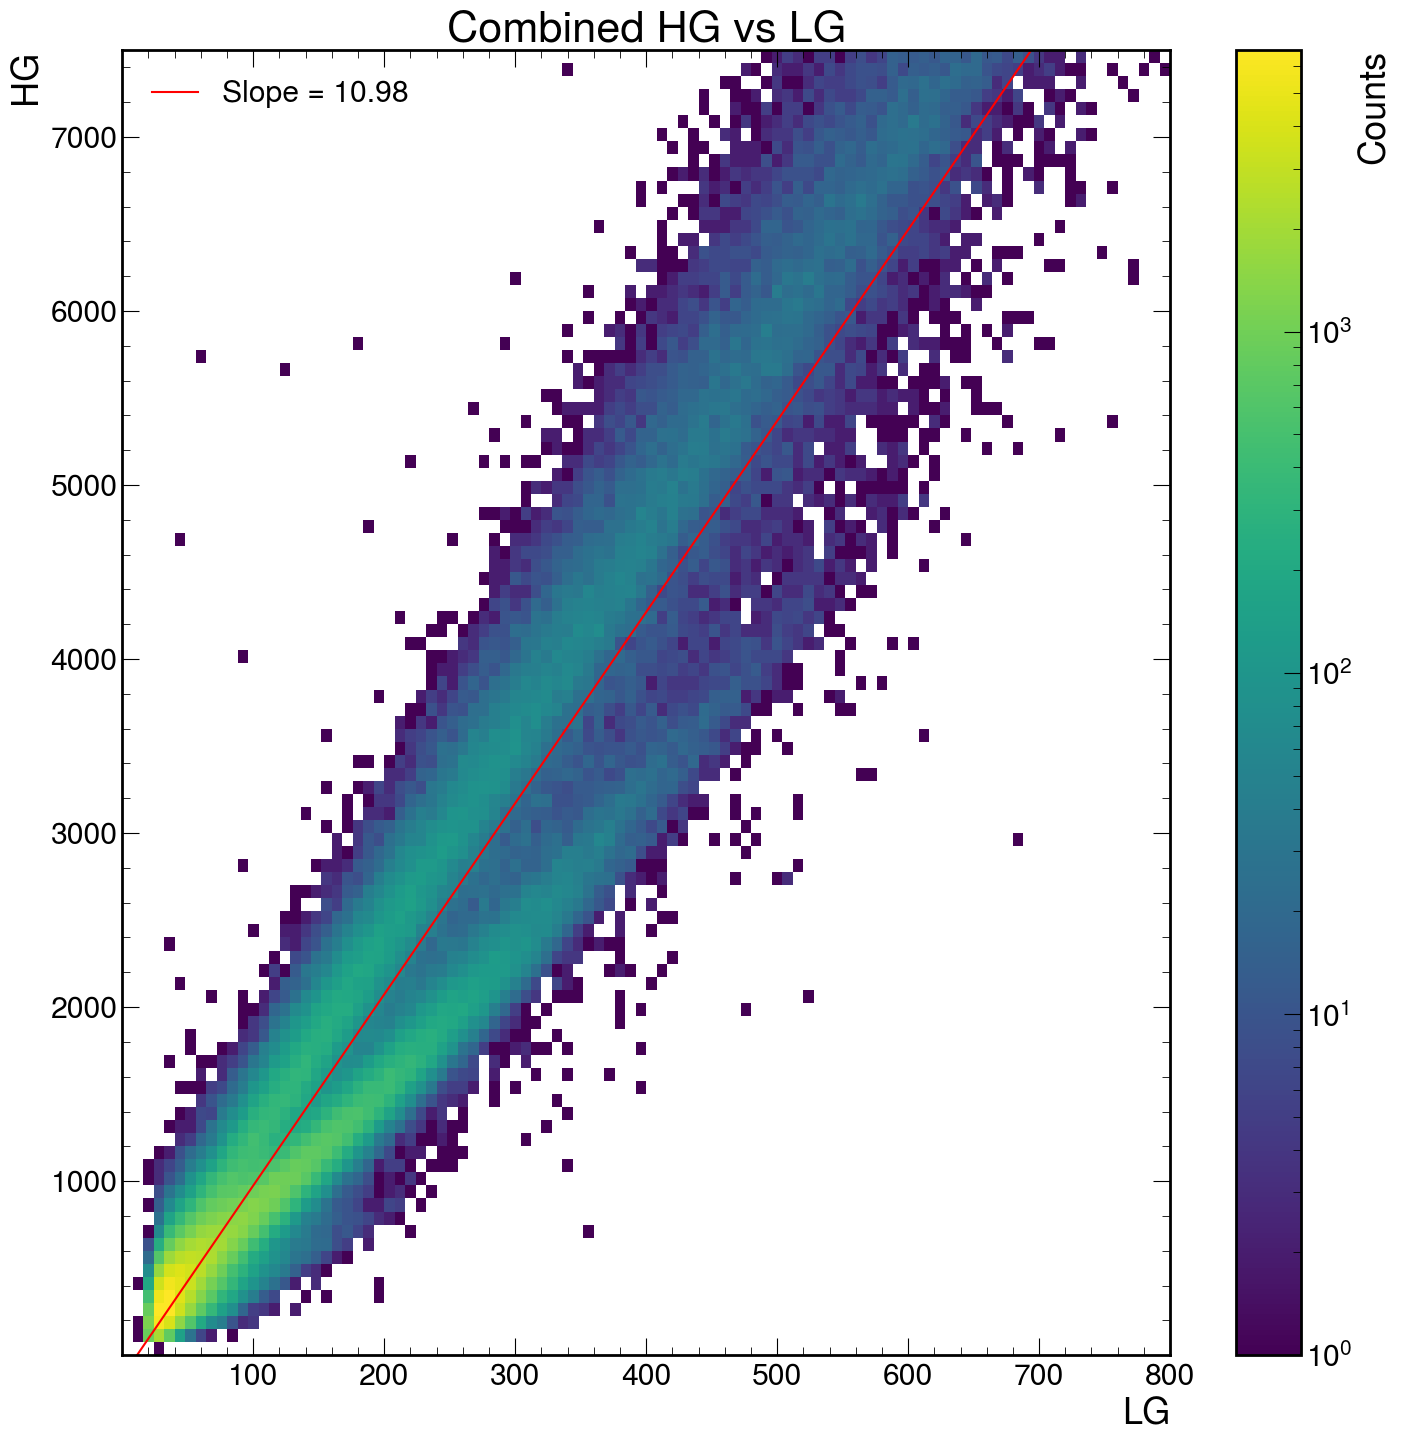

In [19]:
plot_combined_gain(data_df)

(0.0, 20.0)

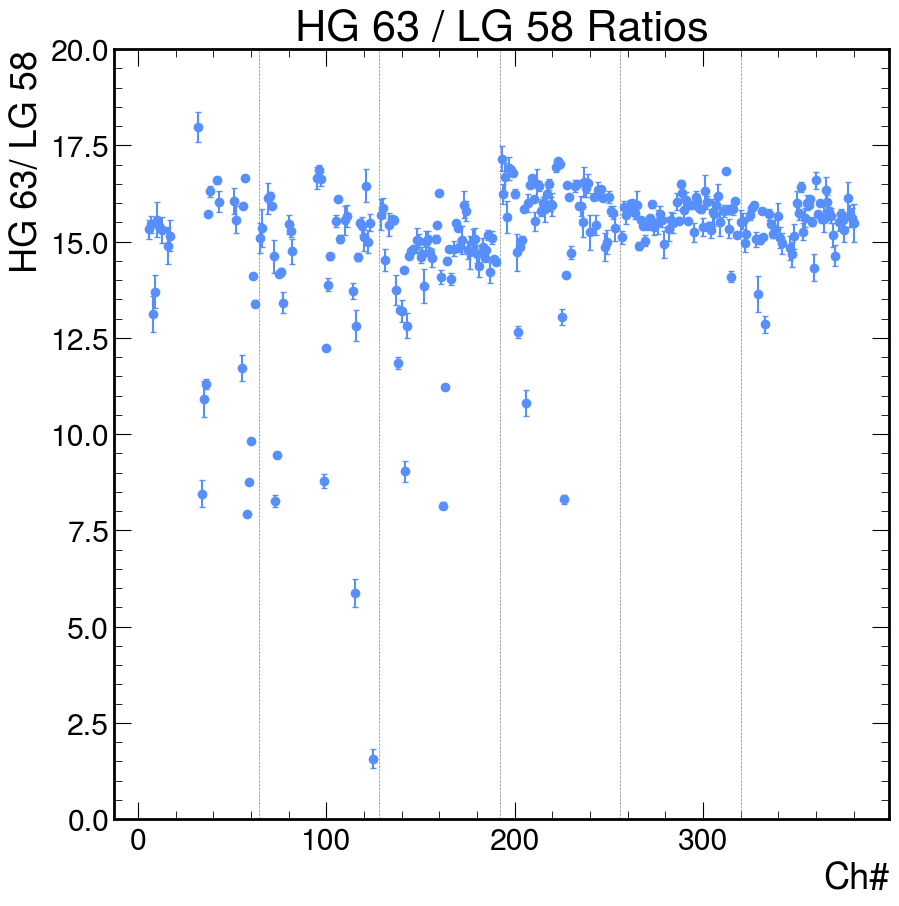

In [35]:
configure_plotting()
GainRatios = np.array(GainRatios)
GainRatiosErr = np.array(GainRatiosErr)
for x in range(64, 64*6, 64):
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
        
plt.errorbar(x=np.array(range(64*6))[GainRatiosErr < 0.5], y=GainRatios[GainRatiosErr < 0.5], yerr=GainRatiosErr[GainRatiosErr < 0.5], fmt='o', capsize=2)
plt.title("HG 63 / LG 58 Ratios")
plt.xlabel("Ch#")
plt.ylabel("HG 63/ LG 58")
plt.ylim(0,20)

<ErrorbarContainer object of 3 artists>

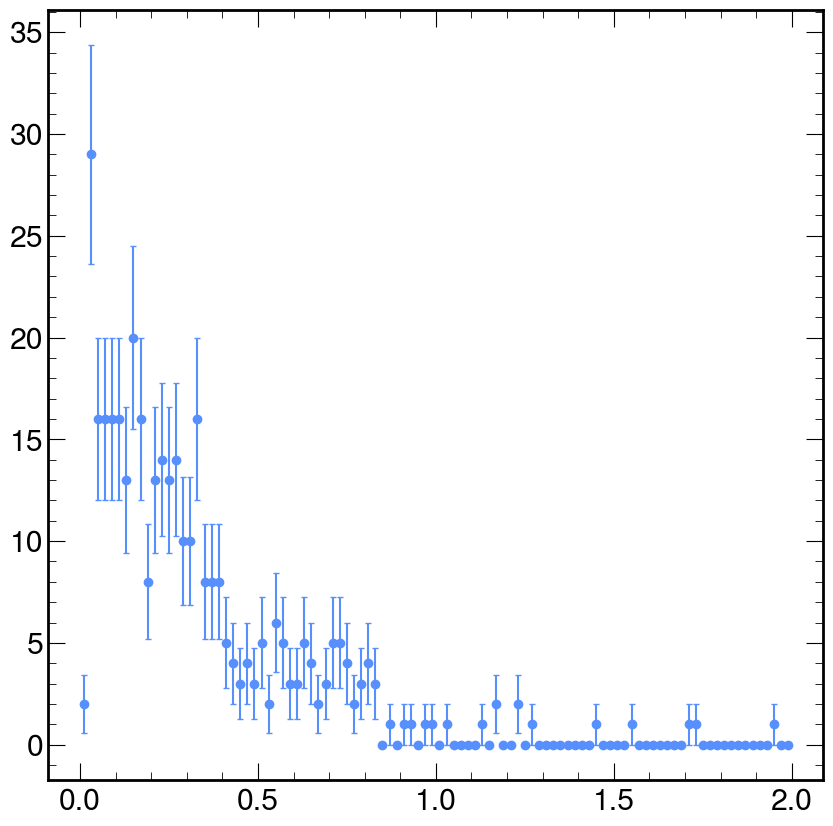

In [36]:
configure_plotting()

counts, bin_edges = np.histogram(GainRatiosErr, bins=100, range=(0, 2))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
plt.errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)

In [37]:
GainRatios = np.array(GainRatios)
GainRatiosErr = np.array(GainRatiosErr)

# Compute average of GainRatios where error < 1
valid_avg = GainRatios[GainRatiosErr < 0.4].mean()

# Create new list applying the replacement
GainRatios_corrected = [
    val if err <= 0.4 else valid_avg
    for val, err in zip(GainRatios, GainRatiosErr)
]

In [38]:
num_channels = len(GainRatios_corrected)

# Calculate CAEN and CAEN_ch from channel index
channels = np.arange(num_channels)
CAEN = channels // 64
CAEN_ch = channels % 64

# Create dataframe
df_gain = pd.DataFrame({
    "channel": channels,
    "CAEN": CAEN,
    "CAEN_ch": CAEN_ch,
    "GainRatio": GainRatios_corrected
})

In [39]:
print(df_gain)

     channel  CAEN  CAEN_ch  GainRatio
0          0     0        0  15.037503
1          1     0        1  15.037503
2          2     0        2  15.037503
3          3     0        3  15.037503
4          4     0        4  15.037503
..       ...   ...      ...        ...
379      379     5       59  15.619596
380      380     5       60  15.037503
381      381     5       61  15.037503
382      382     5       62  15.037503
383      383     5       63  15.037503

[384 rows x 4 columns]


In [40]:
with open('63_60_Ratio_DF.pkl', 'wb') as f:
    pickle.dump(df_gain, f)